In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import pandas as pd 
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import pickle
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import chi2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data1 = pd.read_csv("drive/MyDrive/Final_Project/merged_final1.csv", encoding='latin-1') 
data = data1.sample(frac=1) #to shuffle data
print(data)

                                                Comments  Frequency
22653  Prepare planting holes well, adding plenty of ...         50
11135                He.ll make your life a living hell.         50
33017  Was there one of them in particular you think ...        100
34788                                            Do both          0
18005  War was declared against Austria (1716); the f...         50
...                                                  ...        ...
25175  in.; the test strain required for the iron wir...        100
24716                                  endure suffering.        100
407    There was a gentle air around the woman, and h...          0
9252   One of the best ways to assure children rememb...         50
28724  Under the command of the lord of Lumbres, the ...        100

[35523 rows x 2 columns]


In [ ]:
# removing everything except alphabets`
data['Comments'] = data['Comments'].str.replace("[^a-zA-Z#]", " ")

#converting to string
data['Comments'] = data['Comments'].apply(str)

# removing short words
data['Comments'] = data['Comments'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# make all text lowercase
data['Comments'] = data['Comments'].apply(lambda x: x.lower())

data['Comments']

22653    prepare planting holes well adding plenty orga...
11135                           make your life living hell
33017    was there one them particular you think might ...
34788                                                 both
18005    war was declared against austria the fleet sai...
                               ...                        
25175    the test strain required for the iron wire abo...
24716                                     endure suffering
407      there was gentle air around the woman and her ...
9252     one the best ways assure children remember use...
28724    under the command the lord lumbres the lord tr...
Name: Comments, Length: 35523, dtype: object

In [ ]:

stop_words = stopwords.words('english')

# tokenization
tokens = data['Comments'].apply(lambda x: x.split())

# remove stop-words
filtered_words = tokens.apply(lambda x: [item for item in x if item not in stop_words])

print(filtered_words)
data['Comments'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words
#data['Comments']
#data['tokens']
#filtered_words

22653    [prepare, planting, holes, well, adding, plent...
11135                           [make, life, living, hell]
33017    [one, particular, think, might, responsible, a...
34788                                                   []
18005    [war, declared, austria, fleet, sailed, corfu,...
                               ...                        
25175           [test, strain, required, iron, wire, tons]
24716                                  [endure, suffering]
407      [gentle, air, around, woman, large, brown, eye...
9252     [one, best, ways, assure, children, remember, ...
28724    [command, lord, lumbres, lord, treslong, willi...
Name: Comments, Length: 35523, dtype: object


In [ ]:
data.groupby('Frequency').size()


Frequency
0      10205
50     14417
100    10901
dtype: int64

In [ ]:

X = data.Comments
y = data.Frequency
print(X)

22653    prepare planting holes well adding plenty orga...
11135                                make life living hell
33017    one particular think might responsible annie m...
34788                                                     
18005    war declared austria fleet sailed corfu army c...
                               ...                        
25175                  test strain required iron wire tons
24716                                     endure suffering
407      gentle air around woman large brown eyes lacke...
9252     one best ways assure children remember use sea...
28724    command lord lumbres lord treslong william mar...
Name: Comments, Length: 35523, dtype: object


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

print(X_train)

5842                     hand may feel sense happiness awe
17201    coalition maintained majority government obtai...
12275                 lips found world ceased exist around
20833    women crete pre christian days apparently time...
15970    winterizing clematis complete without protecti...
                               ...                        
32045    another nice prom makeup expression draw eye l...
33371                               key situations forgive
29690    genetics lifestyle deepak chopra gary small sh...
14698    sand driven wheel rail steam jet used starting...
35498                                         please sleep
Name: Comments, Length: 26642, dtype: object


In [ ]:
print("Train set has total {0} entries with {1:.2f}% nonflagged, {2:.2f}% flagged, {3:.2f}% Highly flagged".format(len(X_train),
                                                                             (len(X_train[y_train == 0]) / (len(X_train)))*100,
                                                                            (len(X_train[y_train == 50]) / (len(X_train)))*100,
                                                                            (len(X_train[y_train == 100]) / (len(X_train)))*100))

Train set has total 26642 entries with 28.63% nonflagged, 40.52% flagged, 30.85% Highly flagged


In [ ]:

print("Test set has total {0} entries with {1:.2f}% nonflagged, {2:.2f}% flagged, {3:.2f}% Highly flagged".format(len(X_test),
                                                                             (len(X_test[y_test == 0]) / (len(X_test)))*100,
                                                                            (len(X_test[y_test == 50]) / (len(X_test)))*100,
                                                                            (len(X_test[y_test == 100]) / (len(X_test)))*100))

Test set has total 8881 entries with 29.03% nonflagged, 40.78% flagged, 30.19% Highly flagged


In [ ]:
def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    return accuracy

In [ ]:
rf = RandomForestClassifier()
n_features = np.arange(7104,35523,7104)

def nfeature_accuracy_checker_rf(vectorizer, n_features=n_features, ngram_range=(1, 3), classifier=rf):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Test result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy))
    return result

In [ ]:
clf = DecisionTreeClassifier()

def nfeature_accuracy_checker_clf(vectorizer, n_features=n_features, ngram_range=(1, 3), classifier=clf):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Test result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy))
    return result

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)

def nfeature_accuracy_checker_knn(vectorizer, n_features=n_features, ngram_range=(1, 3), classifier=knn):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Test result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy))
    return result

In [ ]:
tfidf = TfidfVectorizer()
print("Result for trigram with stop words (Tfidf)\n")
feature_result_tgt_rf = nfeature_accuracy_checker_rf(vectorizer=tfidf,ngram_range=(1, 3))
feature_result_tgt_clf = nfeature_accuracy_checker_clf(vectorizer=tfidf,ngram_range=(1, 3))
feature_result_tgt_knn = nfeature_accuracy_checker_knn(vectorizer=tfidf,ngram_range=(1, 3))

Result for trigram with stop words (Tfidf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


Test result for 7104 features
accuracy score: 94.85%
Test result for 14208 features
accuracy score: 94.98%
Test result for 21312 features
accuracy score: 94.98%
Test result for 28416 features
accuracy score: 94.89%
Test result for 35520 features
accuracy score: 95.03%
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_l

In [ ]:
tfidf = TfidfVectorizer()
feature_result_tgt_clf = nfeature_accuracy_checker_clf(vectorizer=tfidf,ngram_range=(1, 3))



In [ ]:
tfidf = TfidfVectorizer()
feature_result_tgt_knn = nfeature_accuracy_checker_knn(vectorizer=tfidf,ngram_range=(1, 3))

In [ ]:
print(feature_result_tgt_rf)
print(feature_result_tgt_clf)
print(feature_result_tgt_knn)

[(7104, 0.9485418308749015), (14208, 0.949780430131742), (21312, 0.949780430131742), (28416, 0.9488796306722216), (35520, 0.9503434297939422)]
[(7104, 0.933340839995496), (14208, 0.9328904402657359), (21312, 0.9342416394550164), (28416, 0.9363810381713771), (35520, 0.9350298389820966)]
[(7104, 0.4494989303006418), (14208, 0.4272041436775138), (21312, 0.4340727395563563), (28416, 0.42461434523139285), (35520, 0.4283301430019142)]


In [ ]:

pipeline = Pipeline([
        ('vectorizer', tfidf),
        ('classifier', rf)
    ])
sentiment_fit = pipeline.fit(X_train, y_train)
y_pred = sentiment_fit.predict(X_test)
#print(X_test,y_test)
#print(y_pred)

print(classification_report(y_test, y_pred, target_names=['nonflagged','flagged','highly flagged']))




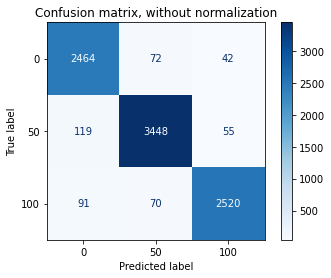

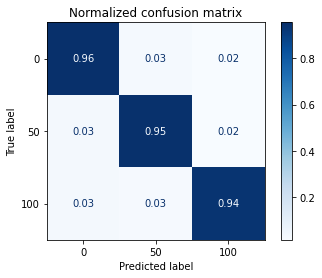

In [ ]:
from sklearn.metrics import plot_confusion_matrix

# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", 'd', None),
                  ("Normalized confusion matrix", '.2f', 'true')]
for title, values_format, normalize in titles_options:
    disp = plot_confusion_matrix(sentiment_fit, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 values_format=values_format,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    #print(title)
    #print(disp.confusion_matrix)

plt.show()

In [ ]:

tfidf = TfidfVectorizer(max_features=20000,ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(data.Comments)
y = data.Frequency
chi2score = chi2(X_tfidf, y)[0]
print(chi2score)

[0.70354988 0.20360283 0.72586085 ... 1.83165355 1.78620511 0.45107118]


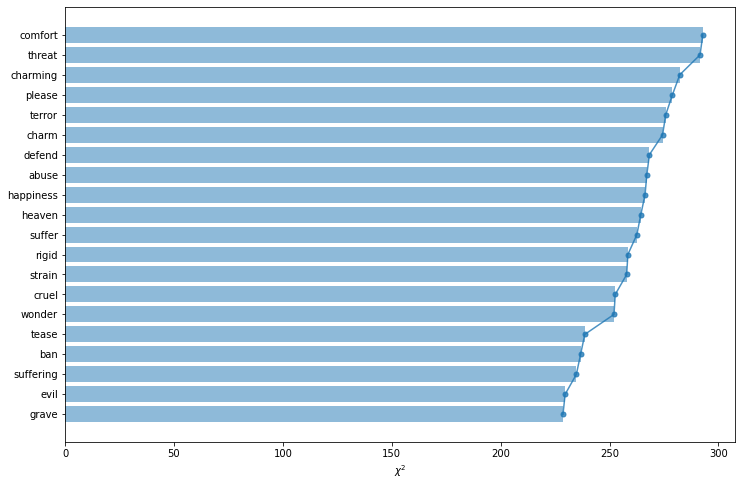

In [ ]:

%matplotlib inline

plt.figure(figsize=(12,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-25:-5]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

In [ ]:
with open('sent.pkl', 'wb') as pickle_out:
     pickle.dump(sentiment_fit, pickle_out)

In [ ]:
#with open('sent.pkl', 'rb') as pickle_in:
   #  unpickled_sent = pickle.load(pickle_in)

In [ ]:
classes = ['Non-Flagged', 'Flagged', 'Highly-Flagged']
y_new = []
y_new1 = []
y_new2 = []
#text = ['You have too much ego of your face I will sue you'] #right
#text = ['Fuck the shit, you bastard'] #right
#text = ['hello'] #right
#text = ['you bastard']  #right
#text = ['Fuck you bastard']   #right
#text = ['I have your nude pics']   #right
#text = ["I am begging leave me alone, don't upload my nudes"] #wrong

#text = ['hello, do you remember me', 'yes ofcourse, how can I forgot you', 'you are the one who had destroyed my life', 'You have too much ego of your face I will sue you', 'Fuck the shit, you bastard', 'hello', 'you bastard', 'I have your nude pics', 'I am begging leave me alone, don\'t upload my nudes']
#text = ['hello, do you remember me', 'yes ofcourse, how can I forgot you', 'you are the one who had destroyed my life', 'srry about that but still i love you', 'ohh silly, just shut you mouth', 'really I love you ', 'just fuck off', 'leaving you was the biggest mistake of my life', 'yes, you had made that mistake', 'srry about that', 'now you have to face it']
text = ['hello', 'how are you', 'i am fine and you?', 'I am also fine', 'what are you doing nowadays', 'i am working in a mnc as a software engineer', 'what about you, you were thinking of some startup', 'yeah, I am workinng on it and it will be ready by next month', 'ohh good to see that, all the best for it', 'thanks mate, let\'s hope for the best']
#y_prob = sentiment_fit.predict(text)
#print(y_prob)
  

In [ ]:
for i in text:
  y_prob =sentiment_fit.predict([i])
  y_prob1 =sentiment_fit1.predict([i])
  y_prob2 =sentiment_fit2.predict([i])
  y_new.append(y_prob)
  y_new1.append(y_prob1)
  y_new2.append(y_prob2)

print(y_new)
avg = sum(y_new)/len(y_new)
print(avg)
if (avg > 50):
  print("Malicious activity detected")
else:
  print("No Malicious activity detected")

print(y_new1)
avg1 = sum(y_new1)/len(y_new1)
print(avg1)
if (avg1 > 50):
  print("Malicious activity detected")
else:
  print("No Malicious activity detected")

print(y_new2)
avg2 = sum(y_new2)/len(y_new2)
print(avg2)
if (avg2 > 50):
  print("Malicious activity detected")
else:
  print("No Malicious activity detected")